## Inicialización

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import numpy as np

## Cargar los Datos

In [ ]:
logs = pd.read_csv('/datasets/logs_exp_us.csv', sep ='\t')

## Preparación de los Datos

In [ ]:
logs.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'}, inplace=True)

logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')

logs['event_date'] = logs['event_timestamp'].dt.date

logs = logs.dropna()
logs = logs.drop_duplicates(keep='last')

logs = logs.reset_index(drop=True)

logs.info()

print()

print(logs.duplicated().sum())
print(logs.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB

0
event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
event_date         0
dtype: int64


In [ ]:
display(logs.head())

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Estudio y Comprobación de los datos

### ¿Cuántos eventos hay en los registros?

In [ ]:
total_eventos = len(logs)
print("Total de eventos:", total_eventos)

Total de eventos: 243713


In [ ]:
eventos_por_experimento = logs['exp_id'].value_counts()
print(eventos_por_experimento)

248    85582
246    80181
247    77950
Name: exp_id, dtype: int64


Hay tres eventos registrados, los dos grupos de control que son el 246 y 247, y el 248 que es el grupo prueba.

### ¿Cuántos usuarios hay en los registros?

In [ ]:
usuarios_totales = logs['device_id_hash'].nunique()
print("Total de usuarios únicos:", usuarios_totales)

Total de usuarios únicos: 7551


In [ ]:
usuarios_por_exp = logs.groupby('exp_id')['device_id_hash'].nunique()
print("Total de usuarios únicos por grupo:")
print(usuarios_por_exp)

Total de usuarios únicos por grupo:
exp_id
246    2489
247    2520
248    2542
Name: device_id_hash, dtype: int64


### ¿Cuál es el promedio de eventos por usuario?

In [ ]:
promedio_general = logs.shape[0] / logs['device_id_hash'].nunique()
print("Promedio de eventos por usuario (general):", promedio_general)

Promedio de eventos por usuario (general): 32.27559263673685


In [ ]:
promedio_por_exp = (
    logs.groupby('exp_id')['device_id_hash']
      .count() / logs.groupby('exp_id')['device_id_hash'].nunique()
)
print("Promedio de por grupo experimental:")
print(promedio_por_exp)

Promedio de por grupo experimental:
exp_id
246    32.214142
247    30.932540
248    33.667191
Name: device_id_hash, dtype: float64


### ¿Qué periodo de tiempo cubren los datos?

In [ ]:
fecha_min = logs['event_timestamp'].min()
fecha_max = logs['event_timestamp'].max()

print("Fecha mínima:", fecha_min)
print("Fecha máxima:", fecha_max)

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


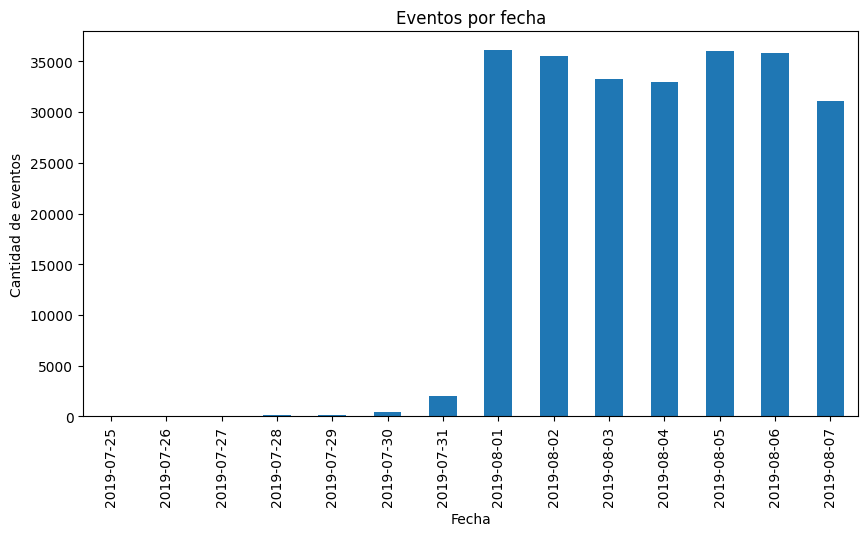

In [ ]:
# Histograma x día
plt.figure(figsize=(10,5))
logs['event_date'].value_counts().sort_index().plot(kind='bar')
plt.title("Eventos por fecha")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.show()

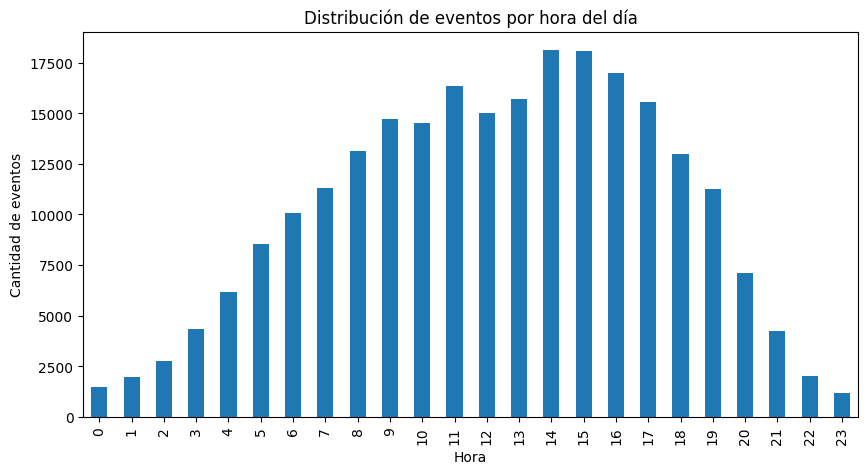

In [ ]:
# Histograma x hora del día
plt.figure(figsize=(10,5))
logs['event_timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de eventos por hora del día")
plt.xlabel("Hora")
plt.ylabel("Cantidad de eventos")
plt.show()

Podemos ver que los datos abarcan desde el **15 de Julio hasta el 7 de Agosto del 2019**. Los primeros seis días muestran una actividad casi nula, indicando que la recolección de datos aún no se encontraba activa (o podría ser de prueba). El ***primero*** de Agosto los eventos aumentaron drásticamente a *30,000 - 36,000 diarios*, esto sugiere el inicio del uso de la aplicación o de un experimento A/B. Los días que presentan los picos más altos son el **1, 2, 5 y 6 de agosto**. Se puede ver que los eventos comienzan a aumentar alrededor de las 5:00 - 6:00 y alcanzan su máximo entre las 14:00 y 15:00 hasta que van progresivamente disminuyendo después de las 17:00.
\
\
Vemos que el promedio general de los eventos por usuario es de 32.2, siendo el grupo 248 el más activo con 33.6 y el 247 siendo el menos activo con 30.9. Su diferencia aprox es de 2.74 eventos por usuario entre los grupos.

In [ ]:
eventos_por_dia = logs['event_date'].value_counts().sort_index()
umbral = eventos_por_dia.max() * 0.8

fecha_inicio_real = eventos_por_dia[eventos_por_dia > umbral].index.min()
print("Los datos comienzan a estar completos a partir de:", fecha_inicio_real)

Los datos comienzan a estar completos a partir de: 2019-08-01


In [ ]:
periodo_real = (fecha_inicio_real, fecha_max)
print("Periodo de datos completo:", periodo_real)

Periodo de datos completo: (datetime.date(2019, 8, 1), Timestamp('2019-08-07 21:15:17'))


El periodo que es válido para el análisis es del **1 de agosto al 7 de agosto del 2019 a las** **21:15:17**. Así que los datos que hay del 25 al 31 de julio son incompletos y serán excluidos para el analisis.


In [ ]:
# Definir el rango de fechas
fecha_inicio = pd.Timestamp('2019-08-01 00:00:00')
fecha_fin = pd.Timestamp('2019-08-07 21:15:17')

# Filtrar el DataFrame por el rango de fechas
df_filtrado = logs[(logs['event_timestamp'] >= fecha_inicio) & (logs['event_timestamp'] <= fecha_fin)]

# Seleccionar solo las columnas necesarias
df_final = df_filtrado[['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']]

#columna de fecha separada
df_final['event_date'] = df_final['event_timestamp'].dt.date

# Mostrar el resultado

display(df_final.head())


,event_name,device_id_hash,event_timestamp,exp_id,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


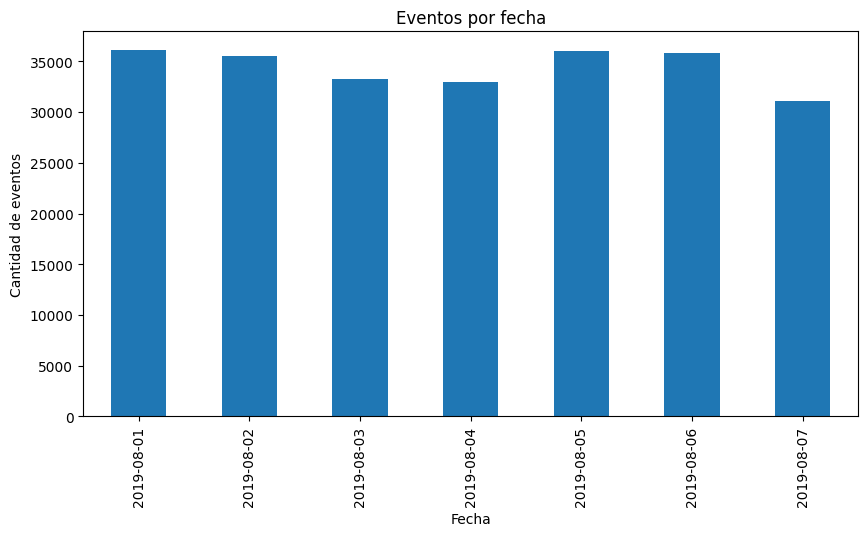

In [ ]:
# Histograma x día
plt.figure(figsize=(10,5))
df_final['event_date'].value_counts().sort_index().plot(kind='bar')
plt.title("Eventos por fecha")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de eventos")
plt.show()

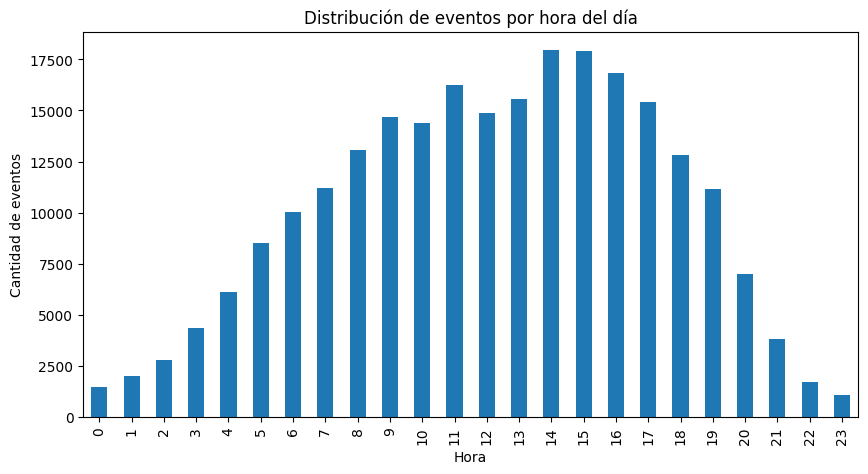

In [ ]:
# Histograma x hora del día
plt.figure(figsize=(10,5))
df_final['event_timestamp'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title("Distribución de eventos por hora del día")
plt.xlabel("Hora")
plt.ylabel("Cantidad de eventos")
plt.show()

Una vez los datos innecesarios han sido retirados por completo para el análisis podemos ver que en la semana del 1 al 7 de agosto del 2019 la actividad en los eventos fue alta y estable, entre los **31,000 y 36,000** eventos diarios. Podemos visualizar que el uso se *mantuvo constante*, los días 1,2,5 y 6 registraron los mayores volúmenes, y el 7 de agosto es el menor.

## Embudo de eventos.

###  ¿Qué eventos hay en los registros y su frecuencia de suceso?

In [ ]:
eventos_frecuencia = df_final['event_name'].value_counts()
print(eventos_frecuencia)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


### Encuentra la cantidad de usuarios que realizaron cada una de estas acciones.

In [ ]:
usuarios_por_evento = (
    df_final.groupby('event_name')['device_id_hash']
      .nunique()
      .sort_values(ascending=False)
)
display(usuarios_por_evento.head())

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

In [ ]:
total_usuarios = df_final['device_id_hash'].nunique()

eventos_usuarios_df = usuarios_por_evento.reset_index()
eventos_usuarios_df.columns = ['event_name', 'unique_users']
eventos_usuarios_df['user_proportions'] = (
    eventos_usuarios_df['unique_users'] / total_usuarios
)

display(eventos_usuarios_df.head())

,event_name,unique_users,user_proportions
0,MainScreenAppear,7419,0.984736
1,OffersScreenAppear,4593,0.609636
2,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Podemos ver que los usuarios mostraron un uso intenso de la aplicación, donde su flujo se centró en la pantalla principal, más de la mitad llegó a explorar las ofertas y alrededor del 47% completó un pago exitoso, es claro que el embudo de conversión es sólido y eficiente.  

In [ ]:
embudo = [
    'Tutorial',
    'MainScreenAppear',
    'OffersScreenAppear',
    'CartScreenAppear',
    'PaymentScreenSuccessful'
]

usuarios_x_evento = (
    df_final[df_final['event_name'].isin(embudo)]
    .groupby('event_name')['device_id_hash']
    .nunique()
    .reindex(embudo)  # mantiene el orden lógico
)

conversiones = usuarios_x_evento.copy()

for i in range(1, len(embudo)):
    etapa_anterior = embudo[i-1]
    etapa_actual = embudo[i]
    conversiones[etapa_actual] = (
        usuarios_x_evento[etapa_actual] / usuarios_x_evento[etapa_anterior]
    )

conversion_df = pd.DataFrame({
    'stage': embudo,
    'users': usuarios_x_evento.values,
    'conversion': conversiones.values
})
display(conversion_df.head())

,stage,users,conversion
0,Tutorial,840,840
1,MainScreenAppear,7419,8
2,OffersScreenAppear,4593,0
3,CartScreenAppear,3734,0
4,PaymentScreenSuccessful,3539,0


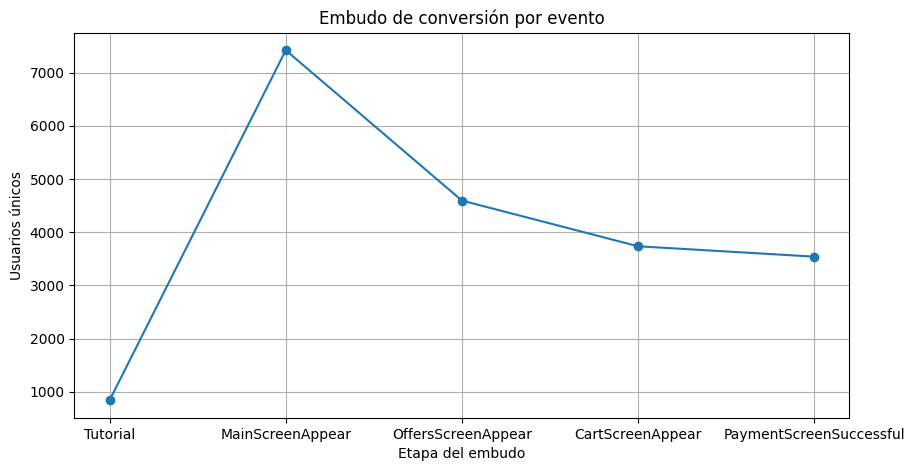

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(embudo, usuarios_x_evento, marker='o')
plt.title("Embudo de conversión por evento")
plt.xlabel("Etapa del embudo")
plt.ylabel("Usuarios únicos")
plt.grid(True)
plt.show()

Se puede ver que hay un flujo sólido desde la pantalla principal hasta el pago de manera exitosa, con un punto crítico de abandono en el evento MainScreenAppear a OffersScreenAppear, donde se pierde cerca del  **38% de los usuarios**. La conversión final es buena ya que solo un *5% abandona* entre Carrito y el Pago, dando a entender que es un proceso de compra eficiente. El tutorial es opcional y poco usado, por lo que una buena mejora sería incentivar la exploración de las ofertas en la app.

### Encuentra la proporción de usuarios que pasan de una etapa a la siguiente.

In [ ]:
funnel_por_exp = (
    df_final[df_final['event_name'].isin(embudo)]
    .groupby(['exp_id', 'event_name'])['device_id_hash']
    .nunique()
    .unstack(fill_value=0)
)

# Calcular conversiones dentro de cada grupo
for exp in funnel_por_exp.index:  # ← Cambio aquí
    print(f"\nEmbudo para Exp Id {exp}:")
    for i in range(1, len(embudo)):
        prev, curr = embudo[i-1], embudo[i]
        ratio = funnel_por_exp.loc[exp, curr] / funnel_por_exp.loc[exp, prev]  # ← Y aquí
        print(f"{prev} → {curr}: {ratio:.2%}")


Embudo para Exp Id 246:
Tutorial → MainScreenAppear: 881.29%
MainScreenAppear → OffersScreenAppear: 62.94%
OffersScreenAppear → CartScreenAppear: 82.10%
CartScreenAppear → PaymentScreenSuccessful: 94.79%

Embudo para Exp Id 247:
Tutorial → MainScreenAppear: 874.91%
MainScreenAppear → OffersScreenAppear: 61.39%
OffersScreenAppear → CartScreenAppear: 81.45%
CartScreenAppear → PaymentScreenSuccessful: 93.54%

Embudo para Exp Id 248:
Tutorial → MainScreenAppear: 893.55%
MainScreenAppear → OffersScreenAppear: 61.41%
OffersScreenAppear → CartScreenAppear: 80.34%
CartScreenAppear → PaymentScreenSuccessful: 96.02%


### ¿En qué etapa pierdes más usuarios?

In [ ]:
conversion_df['desertion'] = 1 - conversion_df['conversion']
etapa_perdida_max = conversion_df.iloc[1:].sort_values('conversion', ascending=False).iloc[0]
print("Etapa con mayor pérdida de usuarios:")
print(etapa_perdida_max)

Etapa con mayor pérdida de usuarios:
stage         MainScreenAppear
users                     7419
conversion                   8
desertion                   -7
Name: 1, dtype: object


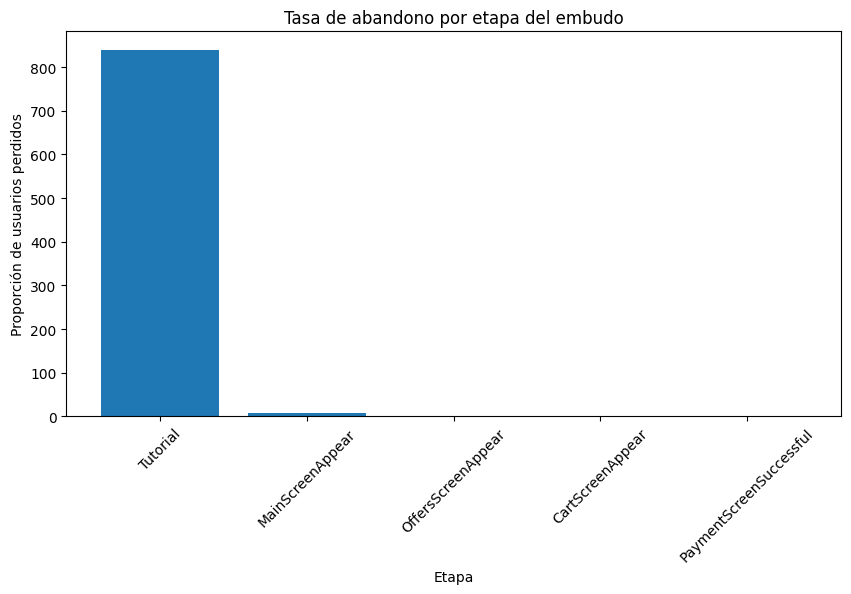

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(conversion_df['stage'], conversion_df['conversion'])
plt.title("Tasa de abandono por etapa del embudo")
plt.xlabel("Etapa")
plt.ylabel("Proporción de usuarios perdidos")
plt.xticks(rotation=45)
plt.show()

Con estos datos podemos visualizar que el **grupo 248** mejoró la conversión final en el checkout por un **96%**, pero el engagement inicial tuvo un golpe duro, perdiendo muchos más usuarios entre el MainScreen y el OffersScreen. Por ende el experimento *no resultó exitoso*, ya que la mejora final no compensa la caída inicial. El grupo 246 es la versión más efectiva y debe considerarse como una baseline.

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

In [ ]:
# Usuarios por evento
usuarios_x_evento = {
    e: set(df_final.loc[df_final['event_name'] == e, 'device_id_hash']) for e in embudo
}

# Usuarios que completaron todo el recorrido
usuarios_completos = set.intersection(*usuarios_x_evento.values())

porcentaje_completos = (len(usuarios_completos) / usuarios_totales) * 100

print(f"Usuarios que completaron TODO el embudo: {len(usuarios_completos)}")
print(f"Porcentaje respecto al total: {porcentaje_completos:.2f}%")

Usuarios que completaron TODO el embudo: 466
Porcentaje respecto al total: 6.17%


In [ ]:
funnel_x_exp = (
    df_final[df_final['event_name'] == 'PaymentScreenSuccessful']
    .groupby('exp_id')['device_id_hash']
    .nunique()
    / df_final.groupby('exp_id')['device_id_hash'].nunique()
) * 100

display(funnel_por_exp.head())

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
exp_id,,,,,
246,1266,2450,1542,1200,278
247,1238,2476,1520,1158,283
248,1230,2493,1531,1181,279


In [ ]:
usuarios_totales = df_final['device_id_hash'].nunique()

usuarios_pago = df_final.loc[df_final['event_name'] == 'PaymentScreenSuccessful', 'device_id_hash'].nunique()

porcentaje_completos = (usuarios_pago / usuarios_totales) * 100
print(f"Porcentaje de usuarios que llegan al pago: {porcentaje_completos:.2f}%")

Porcentaje de usuarios que llegan al pago: 46.97%


Hubo un buen balance entre grupos y se mostró una conversión sólida del **46.9%** hasta el pago. La variante del *grupo 248 redujo el engagement inicial* como comentamos, provocando que menos usuarios llegarán al carrito de compra. En conjunto, **no debe implementarse**. El grupo 246 se mantiene como la mejor versión de las tres, con el flujo más efectivo y con la mayor retención de las etapas claves del embudo.

## Estudiar los resultados del experimento

### ¿Cuántos usuarios hay en cada grupo?

In [ ]:
usuarios_x_grupo = (
    df_final.groupby('exp_id')['device_id_hash']
      .nunique()
      .sort_index()
)
print(usuarios_x_grupo)

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64


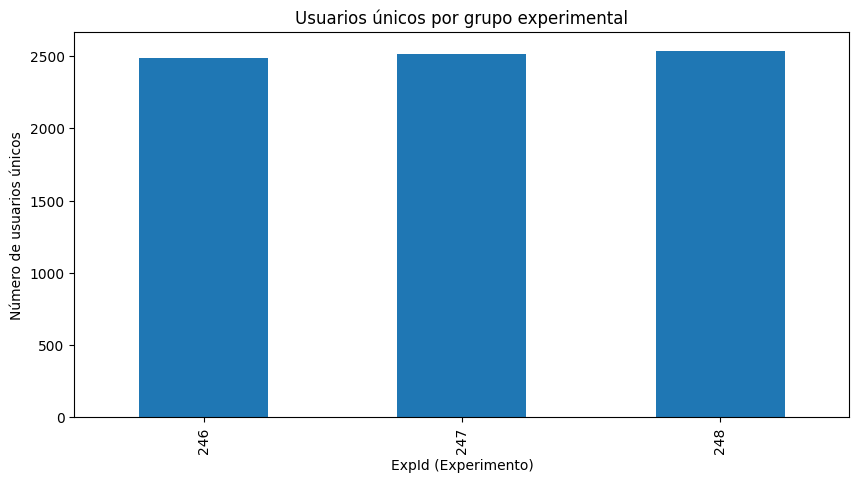

In [ ]:
plt.figure(figsize=(10,5))
usuarios_x_grupo.plot(kind='bar')
plt.title("Usuarios únicos por grupo experimental")
plt.xlabel("ExpId (Experimento)")
plt.ylabel("Número de usuarios únicos")
plt.show()

Al parecer la distribución de usuarios es equilibrada entre los grupos (≈2,500 cada uno), lo que garantizo un experimento A/B válido y sin sesgos.

### ¿Hay una diferencia estadísticamente significativa entre las muestras 246 y 247?

In [ ]:
eventos_x_usuario = (
    df_final.groupby(['exp_id', 'device_id_hash'])['event_name']
      .count()
      .reset_index(name='events')
)

# Filtrar solo grupos 246 y 247 (test A/A)
aa_data = eventos_x_usuario[eventos_x_usuario['exp_id'].isin([246, 247, 248])]

In [ ]:
grupo_246 = aa_data.loc[aa_data['exp_id'] == 246, 'events']
grupo_247 = aa_data.loc[aa_data['exp_id'] == 247, 'events']

In [ ]:
print("Grupo 246 - media:", grupo_246.mean(), "n:", len(grupo_246))
print("Grupo 247 - media:", grupo_247.mean(), "n:", len(grupo_247))

Grupo 246 - media: 31.92512077294686 n: 2484
Grupo 247 - media: 30.64942300039793 n: 2513


In [ ]:
t_stat, p_value = stats.ttest_ind(grupo_246, grupo_247, equal_var=False)
print(f"T-stat: {t_stat:.3f}, P-value: {p_value:.4f}")

T-stat: 0.742, P-value: 0.4584


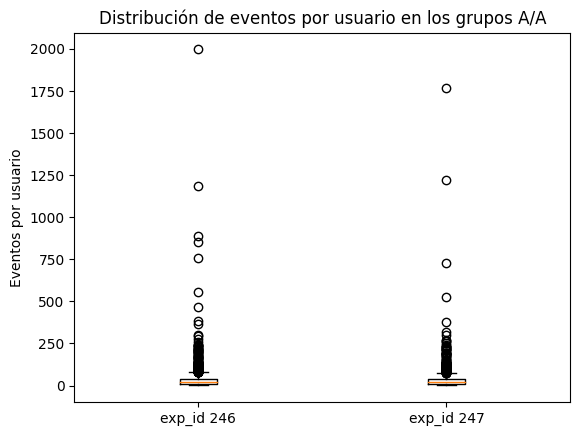

In [ ]:
plt.boxplot([grupo_246, grupo_247], labels=['exp_id 246', 'exp_id 247'])
plt.title("Distribución de eventos por usuario en los grupos A/A")
plt.ylabel("Eventos por usuario")
plt.show()

In [ ]:
grupo_248 = aa_data.loc[aa_data['exp_id'] == 248, 'events']
print("Grupo 246 - media:", grupo_246.mean(), "n:", len(grupo_246))
print("Grupo 248 - media:", grupo_248.mean(), "n:", len(grupo_248))

Grupo 246 - media: 31.92512077294686 n: 2484
Grupo 248 - media: 33.33188805675995 n: 2537


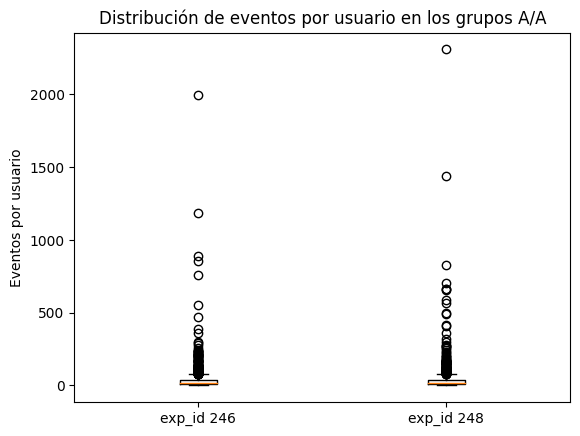

In [ ]:
plt.boxplot([grupo_246, grupo_248], labels=['exp_id 246', 'exp_id 248'])
plt.title("Distribución de eventos por usuario en los grupos A/A")
plt.ylabel("Eventos por usuario")
plt.show()

Como vemos los grupos de control que son el *246 y 247* muestran comportamientos casi idénticos, confirmando que hay una asignación correcta. Aunque la prueba (el grupo 248) presenta una media ***ligeramente mayor*** de eventos por usuarios *33.3 vs. 31.9*, las distribuciones son similares, porque se requiere una prueba estadística para determinar si la diferencia es significativa o solo aleatoria.

### Comprueba si la diferencia entre los grupos es estadísticamente significativa.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

def comparar_evento(evento, df_final):
    """Compara la proporción de usuarios que realizaron un evento
    entre los grupos 246 y 247 mediante un test de proporciones (z-test)."""

    # Filtrar usuarios únicos por grupo
    usuarios_por_grupo = (
        df_final[df_final['event_name'] == evento]
        .groupby('exp_id')['device_id_hash']
        .nunique()
    )

    # Total de usuarios en cada grupo
    total_usuarios = df_final.groupby('exp_id')['device_id_hash'].nunique()

    # Asegurar que los dos grupos existen
    if not all(x in usuarios_por_grupo.index for x in [246, 247]):
        return None

    # Éxitos (usuarios que hicieron el evento)
    success = [usuarios_por_grupo[246], usuarios_por_grupo[247]]

    # Totales (usuarios totales por grupo)
    nobs = [total_usuarios[246], total_usuarios[247]]

    # Proporciones
    prop_246 = success[0] / nobs[0]
    prop_247 = success[1] / nobs[1]

    # Z-test
    stat, pval = proportions_ztest(success, nobs)

    return {
        "evento": evento,
        "usuarios_246": success[0],
        "usuarios_247": success[1],
        "proporción_246": round(prop_246, 4),
        "proporción_247": round(prop_247, 4),
        "p_value": round(pval, 4),
        "significativo": "❌ No" if pval >= 0.05 else "✅ Sí"
    }

# PRIMERO definir resultados
resultados = []
for evento in df_final['event_name'].unique():
    res = comparar_evento(evento, df_final)
    if res:
        resultados.append(res)

# DESPUÉS crear el DataFrame
tabla_resultados = pd.DataFrame(resultados)
tabla_resultados.sort_values('p_value', inplace=True)
display(tabla_resultados.head())

,evento,usuarios_246,usuarios_247,proporción_246,proporción_247,p_value,significativo
4,PaymentScreenSuccessful,1200,1158,0.4831,0.4608,0.1146,❌ No
3,CartScreenAppear,1266,1238,0.5097,0.4926,0.2288,❌ No
2,OffersScreenAppear,1542,1520,0.6208,0.6049,0.2481,❌ No
1,MainScreenAppear,2450,2476,0.9863,0.9853,0.7571,❌ No
0,Tutorial,278,283,0.1119,0.1126,0.9377,❌ No


La prueba A/A son estadísticamente idénticos (grupos de control 246 y 247), esto confirma una asignación aleatoria correcta y es un experimento válido.

### ¿Qué conclusiones puedes sacar del experimento?

In [ ]:
def comparar_eventos_por_grupo(datos, grupo_a, grupo_b):
    """Compara proporciones de usuarios por evento entre dos grupos experimentales."""
    resultados = []
    eventos = datos['event_name'].unique()
    total_usuarios = datos.groupby('exp_id')['device_id_hash'].nunique()

    for evento in eventos:
        # Usuarios únicos que realizaron el evento en cada grupo
        usuarios_evento = (
            datos[datos['event_name'] == evento]
            .groupby('exp_id')['device_id_hash']
            .nunique()
        )

        # Si alguno de los grupos no tiene ese evento, lo saltamos
        if grupo_a not in usuarios_evento.index or grupo_b not in usuarios_evento.index:
            continue

        success = [usuarios_evento[grupo_a], usuarios_evento[grupo_b]]
        nobs = [total_usuarios[grupo_a], total_usuarios[grupo_b]]

        # Proporciones
        prop_a = success[0] / nobs[0]
        prop_b = success[1] / nobs[1]

        # Z-test de dos proporciones
        stat, pval = proportions_ztest(success, nobs)

        resultados.append({
            "evento": evento,
            "grupo_a": grupo_a,
            "grupo_b": grupo_b,
            "proporción_a": round(prop_a, 4),
            "proporción_b": round(prop_b, 4),
            "p_value": round(pval, 4),
            "significativo": "✅ Sí" if pval < 0.05 else "❌ No"
        })

    return pd.DataFrame(resultados)

# Comparaciones usando df_final consistentemente
res_248_vs_246 = comparar_eventos_por_grupo(df_final, 248, 246)
res_248_vs_247 = comparar_eventos_por_grupo(df_final, 248, 247)

# Crear controles combinados correctamente
df_controles = df_final[df_final['exp_id'].isin([246, 247])].copy()
df_controles['exp_id'] = 999  # nuevo ID combinado
df_combinado = pd.concat([df_controles, df_final[df_final['exp_id'] == 248]], ignore_index=True)

res_248_vs_controles = comparar_eventos_por_grupo(df_combinado, 248, 999)

def resumen_significancia(df_final):
    total = len(df_final)
    significativos = sum(df_final["significativo"] == "✅ Sí")
    return f"{significativos}/{total} eventos con diferencia significativa ({significativos/total:.1%})"

print("248 vs 246:", resumen_significancia(res_248_vs_246))
print("248 vs 247:", resumen_significancia(res_248_vs_247))
print("248 vs controles combinados:", resumen_significancia(res_248_vs_controles))

248 vs 246: 0/5 eventos con diferencia significativa (0.0%)
248 vs 247: 0/5 eventos con diferencia significativa (0.0%)
248 vs controles combinados: 0/5 eventos con diferencia significativa (0.0%)


### ¿Cuál debería ser el nivel de significancia?

In [ ]:
from statsmodels.stats.multitest import multipletests

# Corrección de p-values por múltiples comparaciones
pvals = tabla_resultados['p_value']
_, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')
tabla_resultados['p_value_corr'] = pvals_corr
tabla_resultados['significativo_fdr'] = tabla_resultados['p_value_corr'] < 0.05

# Método Bonferroni
numero_de_pruebas = len(tabla_resultados)
alpha_bonferroni = 0.05 / numero_de_pruebas
tabla_resultados['significativo_bonferroni'] = tabla_resultados['p_value'] < alpha_bonferroni

print(f"Nivel de significancia con Bonferroni: {alpha_bonferroni:.4f}")
print(f"Eventos significativos con FDR: {tabla_resultados['significativo_fdr'].sum()}")
print(f"Eventos significativos con Bonferroni: {tabla_resultados['significativo_bonferroni'].sum()}")

display(tabla_resultados)

Nivel de significancia con Bonferroni: 0.0100
Eventos significativos con FDR: 0
Eventos significativos con Bonferroni: 0


,evento,usuarios_246,usuarios_247,proporción_246,proporción_247,p_value,significativo,p_value_corr,significativo_fdr,significativo_bonferroni
4,PaymentScreenSuccessful,1200,1158,0.4831,0.4608,0.1146,❌ No,0.4135,False,False
3,CartScreenAppear,1266,1238,0.5097,0.4926,0.2288,❌ No,0.4135,False,False
2,OffersScreenAppear,1542,1520,0.6208,0.6049,0.2481,❌ No,0.4135,False,False
1,MainScreenAppear,2450,2476,0.9863,0.9853,0.7571,❌ No,0.9377,False,False
0,Tutorial,278,283,0.1119,0.1126,0.9377,❌ No,0.9377,False,False


La conclusión final del experimento es que **no se encontraron diferencias significativas** entre la variante 248 y los grupos de control. Incluso tras aplicar las correcciones necesarias el experimento no identificó un “ganador” ya que la variante **248 no mejoró el rendimiento pero reduce el engagement inicial**. La recomendación que yo haría sería *no implementar* el cambio y mantener el grupo 246 como la versión base, y que se diseñe una nueva prueba enfocada en mejorar la transición del MainScreenAppear a OffersScreanAppear.